In [11]:
import pandas as pd
import numpy as np
from fredapi import Fred
from dotenv import load_dotenv
import os
import src
from src.data import download
from src.features import create_features
from src.models import params,predict_model,train_model,train_predict
from src.visualization import eda,results
from src.custom_funcs import helper_funcs
import importlib

In [2]:
#Download data from FRED API
load_dotenv() #Create environment variable
API_KEY = os.getenv("API_KEY") #Get API_KEY from .env file
fred = Fred(api_key = API_KEY)
###*****Don't change order of the series names*****###
series_fred = ['BAMLC0A0CM','BAMLH0A0HYM2','DCOILWTICO','DTB3','DGS5','DGS10','DGS30','T5YIE','T10YIE','T10Y2Y','T10Y3M','VIXCLS','DEXUSEU','DEXJPUS','DEXUSUK','DEXCHUS']
start_fred = '1/1/1995'
ticker_yf = '^GSPC'
start_yf = '1995-01-01'
interval='1d'
series_names = ['ig_spread','hy_spread','wti','treas_3m','treas_5y','treas_10y','treas_30y','binf_5y','binf_10y','y10_y2','y10_m3','vix','eur','jpy','gbp','cny']

fred_series,sp_data = download.download_data(fred,series_fred,start_fred,ticker_yf,start_yf,interval,series_names)



[*********************100%***********************]  1 of 1 completed


In [3]:
""" Features:
1. S&P 500 returns variance - 5 day,10 day and 21 day
2. IG and HY spread
3. Change in IG and HY spread in bps
4. Change in crude oil prices
5. 3m,5y,10y and 30y yields
6. Change in 3m,5y,10y,30y in bps
7. 5y and 10y breakeven inflation
8. Change in 5y,10y breakeven in bps
9. 2s10s,3m10s
10. Change in 2s10s,3m10s
11. VIX and change in VIX
12. Change in currencies
"""
data_0,feature_num,sp_return,sp_return5,sp_return10,sp_return15 = create_features.derive_features(fred_series,sp_data)


In [4]:
#Create target series
percentile_list = [5,10,15,20,25]
y_5d = helper_funcs.create_target_series(sp_return5,percentile_list,f_horizon=5)
y_10d = helper_funcs.create_target_series(sp_return10,percentile_list,f_horizon=10)
y_15d = helper_funcs.create_target_series(sp_return15,percentile_list,f_horizon=15)
#Reindex features data
data_5d = helper_funcs.reindex_features_data(data_0,5,y_5d)
data_10d = helper_funcs.reindex_features_data(data_0,10,y_10d)
data_15d = helper_funcs.reindex_features_data(data_0,15,y_15d)
#Create feature list
f_names = ['sp_var5','sp_var10','sp_var21','ig_spread','ig_change','hy_spread','hy_change','wti_change','treas3m_change','treas5y_change','treas10y_change','treas30y_change','binf5_change','binf10_change','y10_y2','y10_m3','y10_m3change','y10_y2change','vix_change','eur_change','jpy_change','gbp_change','cny_change']
features_names = pd.DataFrame(f_names,feature_num)


In [ ]:
############################################################# Example:  5 -day ahead model ########################################################################

In [5]:
#Train-test split
train_size,valid_size,test_size = helper_funcs.data_split_size(data_5d,0.75)
x_train,y_train,x_valid,y_valid,x_test,y_test = helper_funcs.data_split(data_5d,y_5d,train_size,valid_size,test_size)

[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.192745
[2]	training's binary_logloss: 0.187184
[3]	training's binary_logloss: 0.182396
[4]	training's binary_logloss: 0.178198
[5]	training's binary_logloss: 0.174573
[6]	training's binary_logloss: 0.171432
[7]	training's binary_logloss: 0.168819
[8]	training's binary_logloss: 0.166505
[9]	training's binary_logloss: 0.164583
[10]	training's binary_logloss: 0.162775
Training - The ROC AUC of model's prediction is: 0.8683075142555688
Validation - The ROC AUC of model's predic

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


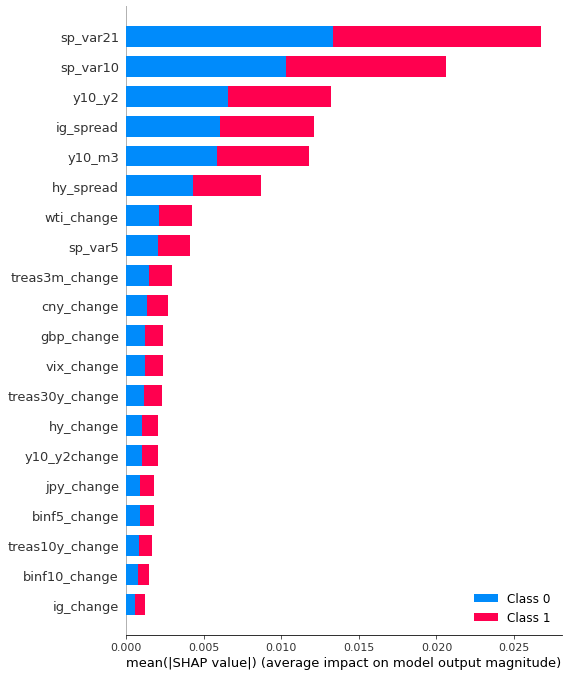

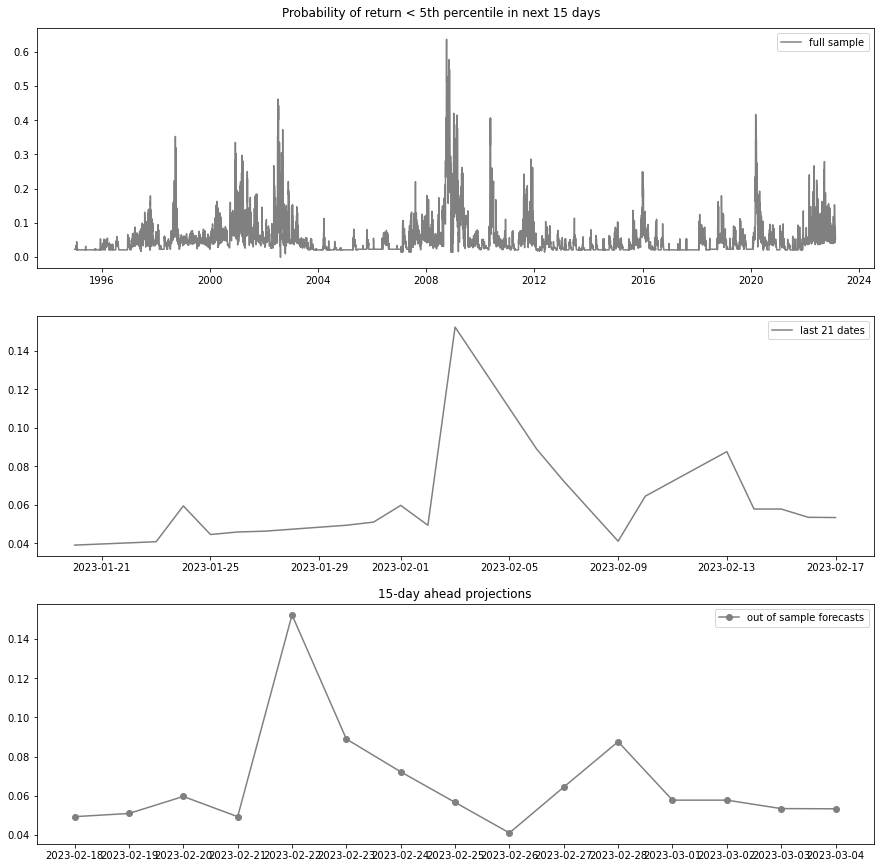

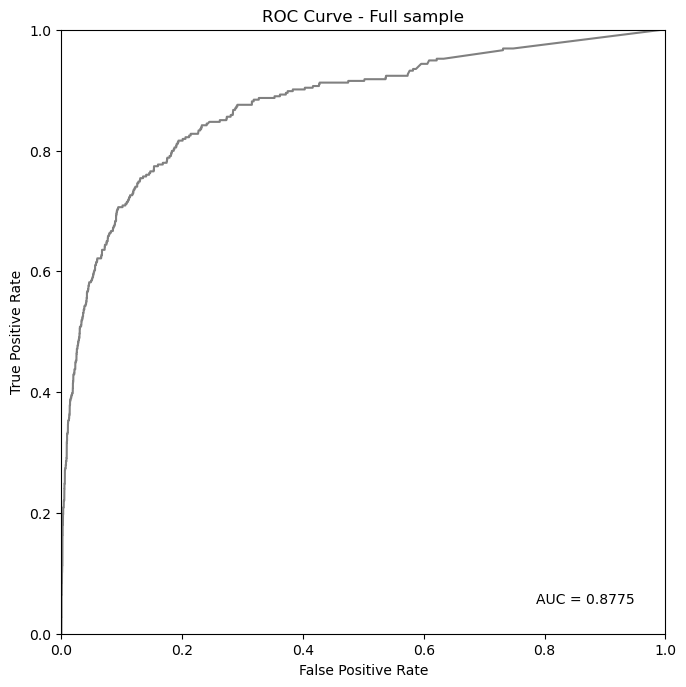

In [12]:
#col_index = 0 (5 percentile),1 (10 percentile),2 (15 percentile),3 (20 percentile),4 (25 percentile)
importlib.reload(params) #IMP: Reload the params.py script before using the attribute params_common
params = params.params_common
train_predict.train_test_pickle(x_train,x_valid,y_train,y_valid,x_test,y_test,col_index=0,num_boost=10,f_horizon=15,params=params,feature_num=feature_num,model_name = 'model_5d1',full_sample_data = data_5d,full_sample_y = y_5d,full_data = data_0,f_names = f_names,percentile= 5)


In [ ]:
############################################################# All models in a loop ########################################################################

In [ ]:
x_data = [data_5d,data_10d,data_15d]
targets_list = [y_5d,y_10d,y_15d]
horizon_list = [5,10,15]
percentile_list = [5,10,15,20,25]
full_data=data_0
params = params.params_common

for x_data,y_data,f_horizon in zip(x_data,targets_list,horizon_list):
    for col_index,percentile in zip(range(5),percentile_list):
        model_name = 'model_' + str(f_horizon) + 'd'+ str(col_index+1)
        train_size,valid_size,test_size = helper_funcs.data_split_size(x_data,0.75)
        x_train,y_train,x_valid,y_valid,x_test,y_test = helper_funcs.data_split(x_data,y_data,train_size,valid_size,test_size)
        helper_funcs.train_test_pickle(x_train,x_valid,y_train,y_valid,x_test,y_test,col_index=col_index,num_boost=10,f_horizon=f_horizon,params=params,feature_num=feature_num,model_name = model_name,full_sample_data = x_data,full_sample_y = y_data,full_data = full_data,f_names = f_names,percentile=percentile)